In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math
import random

import pydot
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

from IPython.display import Image

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.externals.six import StringIO  
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report

from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.anova import anova_lm
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

%matplotlib inline
plt.style.use('seaborn-white')

C:\Users\jkom8\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
def show_grid_search(model, X_train, y_train, tuned_parameters, scores):
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

#        clf = GridSearchCV(
#            svc, tuned_parameters, n_jobs=-1, cv=3,
#            scoring='%s_macro' % score
#        )
        
        clf = GridSearchCV(
            model, tuned_parameters, cv=3,
            verbose=10, scoring='%s_macro' % score, n_jobs=-1
        )
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()

In [3]:
# Load data
df = pd.read_csv("nhl_game_data/game_teams_stats.csv")
# normalize 
df['shots'] = (df['shots'] - df['shots'].mean()) / (df['shots'].max() - df['shots'].min())
df['goals'] = (df['goals'] - df['goals'].mean()) / (df['goals'].max() - df['goals'].min())
df['pim'] = (df['pim'] - df['pim'].mean()) / (df['pim'].max() - df['pim'].min())
df['powerPlayGoals'] = (df['powerPlayGoals'] - df['powerPlayGoals'].mean()) / (df['powerPlayGoals'].max() - df['powerPlayGoals'].min())
df['giveaways'] = (df['giveaways'] - df['giveaways'].mean()) / (df['giveaways'].max() - df['giveaways'].min())
df['takeaways'] = (df['takeaways'] - df['takeaways'].mean()) / (df['takeaways'].max() - df['takeaways'].min())
df['faceOffWinPercentage'] = (df['faceOffWinPercentage'] - df['faceOffWinPercentage'].mean()) / (df['faceOffWinPercentage'].max() - df['faceOffWinPercentage'].min())
df.head()

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways
0,2011030221,1,away,False,OT,Peter DeBoer,0.025695,-0.081415,31,0.009968,3,0.067941,-0.087329,-0.073560,0.002587
1,2011030221,4,home,True,OT,Peter Laviolette,0.125695,0.103770,27,-0.022819,6,0.067941,0.087329,0.120885,-0.094187
2,2011030222,1,away,True,REG,Peter DeBoer,0.125695,0.085252,32,0.009968,4,-0.098726,0.015411,-0.018004,0.002587
3,2011030222,4,home,False,REG,Peter Laviolette,-0.174305,-0.192526,24,0.119258,5,-0.098726,-0.015411,0.009773,-0.029671
4,2011030223,4,away,False,OT,Peter Laviolette,0.025695,-0.044378,28,-0.033747,5,0.067941,0.013699,-0.184671,-0.190961


In [4]:
# Change catergorical data to numerical
df['won_true'] = df['won'].astype(int)
# Features
X = df[['goals', 'shots', 'pim', 'powerPlayGoals', 'giveaways', 'takeaways', 'faceOffWinPercentage']]
# Target Variable
y = df['won_true']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [6]:
svc = SVC()

In [7]:
# Select the optimal C, kernel and gamma parameter by cross-validation
tuned_parameters = [{'kernel':['rbf'], 'C':(0.0001, 0.001, 0.01, .1, 1, 10),
                    'gamma':(0.01, 0.1, 1, 10)}]
#clf = GridSearchCV(svc, tuned_parameters, n_jobs=-1, cv=3, scoring='accuracy', verbose=10)
scores = ['precision', 'recall']

show_grid_search(svc, X_train, y_train, tuned_parameters, scores)

# Tuning hyper-parameters for precision

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  57 out of  72 | elapsed:   32.6s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  65 out of  72 | elapsed:   36.2s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   39.3s finished


Best parameters set found on development set:

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}

Grid scores on development set:

0.251 (+/-0.000) for {'C': 0.0001, 'gamma': 0.01, 'kernel': 'rbf'}
0.251 (+/-0.000) for {'C': 0.0001, 'gamma': 0.1, 'kernel': 'rbf'}
0.251 (+/-0.000) for {'C': 0.0001, 'gamma': 1, 'kernel': 'rbf'}
0.251 (+/-0.000) for {'C': 0.0001, 'gamma': 10, 'kernel': 'rbf'}
0.251 (+/-0.000) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
0.251 (+/-0.000) for {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}
0.753 (+/-0.005) for {'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}
0.763 (+/-0.006) for {'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}
0.251 (+/-0.000) for {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
0.757 (+/-0.002) for {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
0.775 (+/-0.001) for {'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}
0.775 (+/-0.003) for {'C': 0.01, 'gamma': 10, 'kernel': 'rbf'}
0.758 (+/-0.004) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.775 (+/-0.001) for {'C': 0.1, 'gamma': 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  57 out of  72 | elapsed:   30.9s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  65 out of  72 | elapsed:   34.7s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   37.5s finished


Best parameters set found on development set:

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}

Grid scores on development set:

0.500 (+/-0.000) for {'C': 0.0001, 'gamma': 0.01, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 0.0001, 'gamma': 0.1, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 0.0001, 'gamma': 1, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 0.0001, 'gamma': 10, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}
0.549 (+/-0.002) for {'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}
0.763 (+/-0.006) for {'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
0.654 (+/-0.001) for {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
0.775 (+/-0.001) for {'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}
0.775 (+/-0.003) for {'C': 0.01, 'gamma': 10, 'kernel': 'rbf'}
0.660 (+/-0.004) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.774 (+/-0.001) for {'C': 0.1, 'gamma': 

In [14]:
#{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
svc2 = SVC(kernel='rbf', C=0.1, gamma=1, probability=True)
svc2.fit(X_train, y_train)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

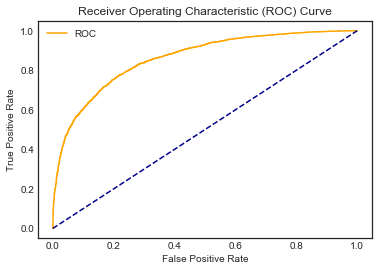

0.859857270855328

In [15]:
# function for printing the ROC curve
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

y_probs = svc2.predict_proba(X_test) # we have to get the probability values to plot roc curve
y_probs = y_probs[:, 1] # keep probabilities for the positive outcome only
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plot_roc_curve(fpr, tpr)
svc2_auc = roc_auc_score(y_test, y_probs)
svc2_auc